# Project 2

<bk>
    Dieter Brehm and Corinne Wilklow

In [49]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [50]:
m = UNITS.meter
ft =  UNITS.foot
inch = UNITS.inch


W = UNITS.watt

J = UNITS.joule
btu = UNITS.btu

degC = UNITS.celsius
K = UNITS.kelvin
degF = UNITS.fahrenheit 

hr = UNITS.hour

<Unit('hour')>

In [81]:
R_data = pd.read_csv('R_values1.csv', header=0, index_col=0, usecols=range(1,2))
print(R_data.head)

<bound method NDFrame.head of Empty DataFrame
Columns: []
Index: [1.25, 3.71, 3.85, 4.0, 4.13, 4.29, 5.0, 5.0, 6.5, 7.2]>


In [82]:
ext_data = pd.read_csv('DataOWall.csv', parse_dates=[0], index_col=0, header=0, skiprows=[1,2])
ext_data.head()

,Q_in,Q_out,T_int,T_ext
2014-10-05 16:30:00,10.994,6.840,16.92,14.68
2014-10-05 16:35:00,10.952,6.012,16.92,14.69
2014-10-05 16:40:00,10.882,7.040,16.93,14.66
2014-10-05 16:45:00,10.798,8.880,16.93,14.59
2014-10-05 16:50:00,10.756,10.491,16.94,14.50


Convert Index entries to seconds, noticing the spacing between recordings

In [83]:
timestamp_0 = get_first_label(ext_data)
time_deltas = ext_data.index - timestamp_0;

In [84]:
ext_data.index = time_deltas.days * 86400 + time_deltas.seconds
ext_data.head()

,Q_in,Q_out,T_int,T_ext
0,10.994,6.840,16.92,14.68
300,10.952,6.012,16.92,14.69
600,10.882,7.040,16.93,14.66
900,10.798,8.880,16.93,14.59
1200,10.756,10.491,16.94,14.50


Add units to each dataframe (Q_in, Q_out, T_int, T_ext)

In [85]:
ext_data.Q_in.units = W / m**2
ext_data.Q_out.units = W / m**2
ext_data.T_int.units = degC
ext_data.T_ext.units = degC;

In [86]:
def make_system(init, R, d, SA, m, c):
    """Make a system object for the HIV model.
    
    start_temp: starting temp of room 
    gamma: recovery rate in days
    
    returns: System object
    """
    

    t0 = 0
    t_end = 20
    dt = .5

    return System(init=init, t0=t0, t_end=t_end, dt=dt, R=R, d=d, SA=SA, m=m, c=c)

In [87]:
init = State(T_int=60, T_ext=get_first_value(ext_data.T_ext)*9/5+32)
R = 3 #ft^2*deg5/btu/hr/in
d = 4 #inches

#room dimensions
l = 6 #m
w = 6 #m
h = 6 #m

SA = (l * w * 4 + h * l * 2) * 10.7639 #ft^2
V = l * w * h #m^3

rho = 1 #density of air
g = 9.8 #m/s^2, acceleration due to gravity
m = (rho * V * g) * 2.2 #mass of air in room in lb

c = 0.171 #btu/lbm*R

system = make_system(init, R, d, SA, m, c)

,values
init,T_int 60.000 T_ext 58.424 dtype: float64
t0,0
t_end,20
dt,0.5
R,3
d,4
SA,2325
m,4656.96
c,0.171


In [88]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end,system.dt):
        frame.row[t+system.dt] = update_func(frame.row[t], t, system)
    
    return frame

In [89]:
def update_func(state, t, system):
    """Update the model.
    
    state: State with variables T_int, T_ext
    dt: time step
    system: System
    
    returns: State object
    """
    
    T_int, T_ext = state
    
    delta_T = T_int - T_ext
    
    dQ= (system.SA * delta_T / (system.R * system.d)) * system.dt
   
    if system.c==0:
        system.c = dQ / delta_T
    
    
    dT = dQ / (system.c * system.m) 
    
    T_int = T_int - dT
    
    #print(dT)
    
    return State(T_int = T_int, T_ext = T_ext)

In [102]:
def sweep_R(R_data):
    '''Sweep a range of values of R
    R =  different R values correlated to specific insulations
    returns SweepSeries'''
    #print("r_data", R_data.index.values)
    insulation = ['plywood','EcoTouch','R-tech','Kingspan','Comfortbatt gold','Comfortbatt blue',
                                      'Foamular','SilveRboard','Super TUFF','polyisocyanurate (foil-faced)']
    for R in R_data.index.values:
        systemr = make_system(init, R, d, SA, m, c)
        results = run_simulation(systemr, update_func)
        plot(results.T_int)
        #print(results.T_int)
    plt.legend()
    decorate(title = 'Temperature loss vs Time',
            xlabel = 'time(hrs)',
            ylabel = 'Temperature(degrees F)')
    plt.show()

No handles with labels found to put in legend.


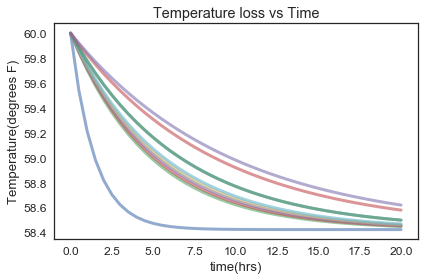

In [103]:
sweep_R(R_data)

In [76]:
update_func(system.init, system.t0, system)

,values
T_int,59.808279
T_ext,58.424000


In [77]:
results = run_simulation(system,update_func)

,T_int,T_ext
0.0,60.000000,58.424
0.5,59.808279,58.424
1.0,59.639881,58.424
1.5,59.491968,58.424
2.0,59.362050,58.424
2.5,59.247936,58.424
3.0,59.147703,58.424
3.5,59.059665,58.424
4.0,58.982336,58.424
4.5,58.914414,58.424


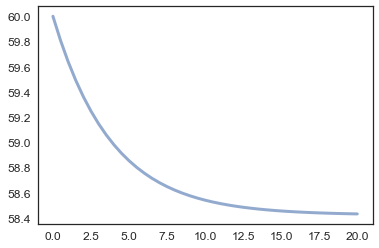

In [78]:
plot(results.T_int)